In [7]:
def z(n, c):
    if n == 0:
        return 0
    else:
        return z(n - 1, c) ** 2 + c

In [8]:
for n in range(10):
    print(f"z({n}) = {z(n, c=1)}")

z(0) = 0
z(1) = 1
z(2) = 2
z(3) = 5
z(4) = 26
z(5) = 677
z(6) = 458330
z(7) = 210066388901
z(8) = 44127887745906175987802
z(9) = 1947270476915296449559703445493848930452791205


In [9]:
def sequence(c, z=0):
    while True:
        yield z
        z = z ** 2 + c

In [10]:
def mandelbrot(candidate):
    return sequence(z=0, c=candidate)


def julia(candidate, parameter):
    return sequence(z=candidate, c=parameter)

In [13]:
import numpy as np

np.warnings.filterwarnings("ignore")


def complex_matrix(xmin, xmax, ymin, ymax, pixel_density):
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixel_density))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixel_density))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j

In [14]:
def is_stable(c, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = z ** 2 + c
    return abs(z) <= 2

In [15]:
def get_members(c, num_iterations):
    mask = is_stable(c, num_iterations)
    return c[mask]

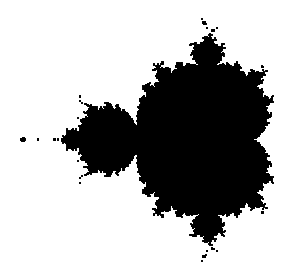

In [22]:
import matplotlib.pyplot as plt

c = complex_matrix(-2.1, 1, -2, 2, pixel_density=512)
members = get_members(c, num_iterations=50)

plt.scatter(members.real, members.imag, color="black", marker=",", s=1)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

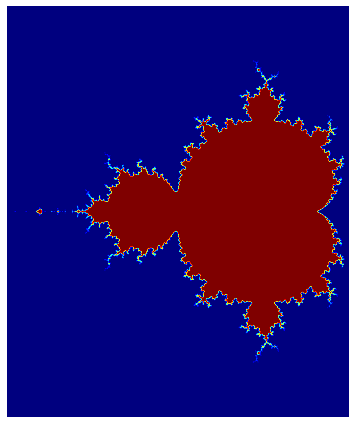

In [24]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)
plt.figure(figsize=(10, 6))
plt.imshow(is_stable(c, num_iterations=20), cmap="jet")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

In [27]:
from PIL import Image

c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=2048)
image = Image.fromarray(~is_stable(c, num_iterations=20))
image.show()

In [40]:
from dataclasses import dataclass
from math import log


@dataclass
class MandelbrotSet:
    max_iterations: int
    escape_radius: float = 2.0

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex, smooth=False, clamp=True) -> float:
        value = self.escape_count(c, smooth) / self.max_iterations
        return max(0.0, min(value, 1.0)) if clamp else value

    def escape_count(self, c: complex, smooth=False) -> float:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > self.escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return self.max_iterations

In [42]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
width, height = 512, 512
scale = 0.0075
GRAYSCALE = "L"

image = Image.new(mode=GRAYSCALE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 2, height / 2 - y)
        instability = 1 - mandelbrot_set.stability(c, smooth=True)
        image.putpixel((x, y), int(instability * 255))

image.show()

In [45]:
@dataclass
class Viewport:
    image: Image.Image
    center: complex
    width: float

    @property
    def height(self):
        return self.scale * self.image.height

    @property
    def offset(self):
        return self.center + complex(-self.width, self.height) / 2

    @property
    def scale(self):
        return self.width / self.image.width

    def __iter__(self):
        for y in range(self.image.height):
            for x in range(self.image.width):
                yield Pixel(self, x, y)


@dataclass
class Pixel:
    viewport: Viewport
    x: int
    y: int

    @property
    def color(self):
        return self.viewport.image.getpixel((self.x, self.y))

    @color.setter
    def color(self, value):
        self.viewport.image.putpixel((self.x, self.y), value)

    def __complex__(self):
        return (
                complex(self.x, -self.y)
                * self.viewport.scale
                + self.viewport.offset
        )

In [46]:
image = Image.new(mode="1", size=(512, 512), color=1)
for pixel in Viewport(image, center=-0.75, width=3.5):
    if complex(pixel) in mandelbrot_set:
        pixel.color = 0

image.show()

In [49]:
mandelbrot_set = MandelbrotSet(max_iterations=256, escape_radius=1000)

image = Image.new(mode="L", size=(1024, 1024))
for pixel in Viewport(image, center=-0.7435 + 0.1314j, width=0.002):
    c = complex(pixel)
    instability = 1 - mandelbrot_set.stability(c, smooth=True)
    pixel.color = int(instability * 255)

from PIL import ImageEnhance

enhancer = ImageEnhance.Brightness(image)
enhancer.enhance(1.25).show()

In [50]:
def paint(mandelbrot_set, viewport, palette, smooth):
    for pixel in viewport:
        stability = mandelbrot_set.stability(complex(pixel), smooth)
        index = int(min(stability * len(palette), len(palette) - 1))
        pixel.color = palette[index % len(palette)]

In [51]:
def denormalize(palette):
    return [
        tuple(int(channel * 255) for channel in color)
        for color in palette
    ]

In [53]:
import matplotlib.cm

colormap = matplotlib.cm.get_cmap("twilight").colors
palette = denormalize(colormap)

In [55]:
mandelbrot_set = MandelbrotSet(max_iterations=128, escape_radius=1000)
image = Image.new(mode="RGB", size=(1024, 1024))
viewport = Viewport(image, center=-0.7435 + 0.1314j, width=0.002)
paint(mandelbrot_set, viewport, palette, smooth=True)
image.show()

In [56]:
exterior = [(1, 1, 1)] * 50
interior = [(1, 1, 1)] * 5
gray_area = [(1 - i / 44,) * 3 for i in range(45)]
palette = denormalize(exterior + gray_area + interior)

In [57]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
viewport = Viewport(image, center=-0.75, width=3.5)
paint(mandelbrot_set, viewport, palette, smooth=True)
image.show()

In [58]:
from scipy.interpolate import interp1d


def make_gradient(colors, interpolation="linear"):
    X = [i / (len(colors) - 1) for i in range(len(colors))]
    Y = [[color[i] for color in colors] for i in range(3)]
    channels = [interp1d(X, y, kind=interpolation) for y in Y]
    return lambda x: [np.clip(channel(x), 0, 1) for channel in channels]

In [59]:
black = (0, 0, 0)
blue = (0, 0, 1)
maroon = (0.5, 0, 0)
navy = (0, 0, 0.5)
red = (1, 0, 0)

colors = [black, navy, blue, maroon, red, black]
gradient = make_gradient(colors, interpolation="cubic")

gradient(0.42)

[0.026749999999999954, 0.0, 0.9435000000000001]

In [60]:
num_colors = 256
palette = denormalize([
    gradient(i / num_colors) for i in range(num_colors)
])

len(palette)
256
palette[127]
(46, 0, 143)

(46, 0, 143)

In [62]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
paint(mandelbrot_set, viewport, palette, smooth=True)
image.show()

In [63]:
from PIL.ImageColor import getrgb


def hsb(hue_degrees: int, saturation: float, brightness: float):
    return getrgb(
        f"hsv({hue_degrees % 360},"
        f"{saturation * 100}%,"
        f"{brightness * 100}%)"
    )


hsb(360, 0.75, 1)

(255, 64, 64)

In [65]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
for pixel in Viewport(image, center=-0.75, width=3.5):
    stability = mandelbrot_set.stability(complex(pixel), smooth=True)
    pixel.color = (0, 0, 0) if stability == 1 else hsb(
        hue_degrees=int(stability * 360),
        saturation=stability,
        brightness=1,
    )

image.show()